Note: This notebook demonstrates how to adapt a design generated using the stratified desgin algorithm (SDA). To run this notebook you will need to have generated an original design, using the **demo-stratified-design** notebook. Example images provided in the raw file can be used to test the methods.

### Import required libraries

In [1]:
import os
from osgeo import gdal, osr
import pyproj as pyproj
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Option 1: Manually update invalid areas mask

## Option 2: Exclude radius around a specific site

In [ ]:
def update_mask(site_df, mask, radius, res):
    imheight, imwidth = mask.shape
    mask_update = np.ones((imheight, imwidth))
    # Code the point to mask as a zero
    center_pixel = site_df.loc[site_df['sampled']==2]
    x = center_pixel['row'].values; y = center_pixel['col'].values
    mask_update[x, y] = 0
    # Threshold distance transform and add to original mask
    dist_im = ndimage.distance_transform_edt(mask_update)*res
    dist_im[dist_im<radius] = 0; dist_im[dist_im>=radius] = 1
    

In [4]:
mask, nbins, res, GeoT, auth_code = get_file_info(mask_path)

In [5]:
imheight, imwidth = mask.shape

In [6]:
mask_update = np.ones((imheight, imwidth))

In [7]:
x = 300; y = 300

In [8]:
mask_update[x, y] = 0

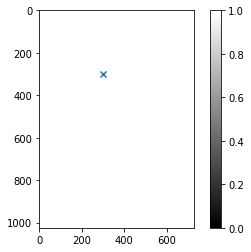

In [16]:
plt.imshow(mask_update, cmap='gray')
plt.colorbar()
plt.scatter(y, x, marker='x')
plt.show()

In [11]:
dist_im = ndimage.distance_transform_edt(mask_update)*res

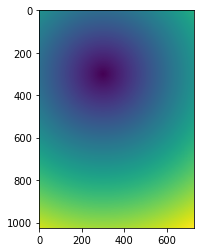

In [12]:
plt.imshow(dist_im)
plt.show()

### Configuration parameters: Enter own values

Specify a unique name for the project as `save_folder`. A folder with your chosen name will be created in the results folder, and all outputs for the design will be saved there. E.g:

In [78]:
save_folder = 'Stratified_Design_Demo'

Enter path to invalid areas mask (`mask_path`). This should be in GeoTiff format and saved in the 'raw' data folder. E.g:

In [3]:
mask_path = 'raw/InvalidAreasMask.tif'

Enter path to .csv file which has been tagged with sampled and unsampled codes. E.g:

In [80]:
sampled_df = 'results/Stratified_Design_Demo/2019_02_25_121053_30Site_Stratified_tagged.csv'

### Load data

In [2]:
def get_file_info(file_path):
    file_raw = gdal.Open(file_path)
    prj = file_raw.GetProjection(); srs = osr.SpatialReference(wkt=prj)
    auth_code = srs.GetAuthorityCode(None)
    GeoT = file_raw.GetGeoTransform(); res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, auth_code

In [82]:
print('Loading {} ...'.format(mask_path))

mask, nbins, res, GeoT, auth_code = get_file_info(mask_path)

print('\nNumber of categories in mask (should only be two): {}'.format(nbins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(GeoT))
print('Authority code: {}'.format(auth_code))

Loading raw/InvalidAreasMask.tif ...

Number of categories in mask (should only be two): 2
Pixel resolution (m): 30.0
GeoT info: (604343.5084861958, 30.0, 0.0, 5302852.190465175, 0.0, -30.0)
Authority code: 32759


**Plot mask**: Check that invalid areas are coded as 0, and 1 for valid areas

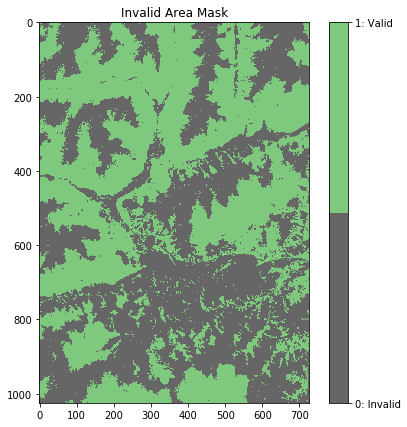

In [83]:
plt.figure(figsize=(7, 7))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.show()

## Generate stratified design

In [84]:
def update_stratified_design(mask, nsp, sampled_df):

    imheight, imwidth = mask.shape
    nsampled = len(sampled_df)
    sampled_x = sampled_df['row'].values
    sampled_y = sampled_df['col'].values

    sites = np.ones((imheight, imwidth))
    sites[sampled_x, sampled_y] = 0
    mask_aux = copy(mask)
    x_vals = [sampled_x]
    y_vals = [sampled_y]

    for i in range(nsp - nsampled):


        # Generate EDT image of all sampled/selected sites
        dist_im = ndimage.distance_transform_edt(sites) * mask
        # Extract coordinates with the maximum distance value
        dist_mx = zip(*np.where(dist_im == dist_im.max()))

        # Choose one maximum coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Make all elements of EDT map in invalid region 0
        dist_im = dist_im * mask_aux
        # Extract coords of pixels with maximum distance value
        dist_mx = zip(*np.where(dist_im == dist_im.max()))

        # Choose one max coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Save x and y coords
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Code chosen site to be zero (a feature pixel) in site array
        sites[x, y] = 0

        # Update the euclidean distance transform
        # dist_im = ndimage.distance_transform_edt(sites)
    xy0 = np.hstack([x_vals, y_vals])
    return xy0

In [85]:
x_strat, y_strat = generate_stratified_design(mask, nsp)

Plotting site 1
Plotting site 2
Plotting site 3
Plotting site 4
Plotting site 5
Plotting site 6
Plotting site 7
Plotting site 8
Plotting site 9
Plotting site 10
Plotting site 11
Plotting site 12
Plotting site 13
Plotting site 14
Plotting site 15
Plotting site 16
Plotting site 17
Plotting site 18
Plotting site 19
Plotting site 20
Plotting site 21
Plotting site 22
Plotting site 23
Plotting site 24
Plotting site 25
Plotting site 26
Plotting site 27
Plotting site 28
Plotting site 29
Plotting site 30
Stratified sample design complete!


# Results

Generate results folder for given project (if the folder already exists it will not overwrite, additional results will just be added to the existing folder)

In [86]:
directory = 'results/{}'.format(save_folder)
if not os.path.exists(directory):
    os.makedirs(directory)

# Create unique time stamp to add to file names (to avoid overwriting)
ts = time.gmtime()
ts = time.strftime("%Y_%m_%d_%H%M%S", ts)

print('Results will be saved in the folder {}'.format(directory))
print('Files will start with the time stamp {}'.format(ts))

Results will be saved in the folder results/Stratified_Design_Demo
Files will start with the time stamp 2019_02_25_121053


### Plot Design

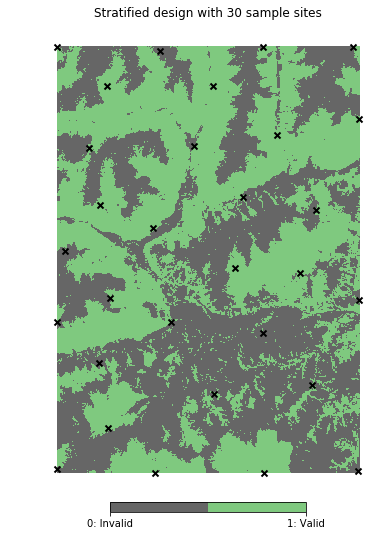

In [87]:
plt.figure(figsize=(7, 9))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('{} design with {} sample sites'.format('Stratified', len(x_strat)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.02, orientation='horizontal', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.scatter(y_strat, x_strat, c='black', marker='x', linewidth=2)
plt.savefig('{}/{}_{}Site_Stratified_Plot.tif'.format(directory, ts, nsp))
plt.show()

The Stratified Design Algorithm (SDA) produces a layout where sites are spread evenly spatially, given the constraints of the valid sample areas. 

### Save the design

The below function converts the (x, y) coordinates specifying pixels in the image to longitude and latitude coordinates. Geo-information extracted from the input "invalid areas mask" is used to transform the points to long-lat. 

In [88]:
def LongLatConvert(x, y, GeoT, auth_code):
    x_proj = x * GeoT[1] + GeoT[0] + (GeoT[1] / 2)
    y_proj = y * GeoT[5] + GeoT[3] + (GeoT[5] / 2)
    p1 = pyproj.Proj(init='EPSG:'+auth_code)
    longlat = p1(x_proj, y_proj, inverse=True)
    return longlat

In [89]:
# Convert from row/col to projected
longlat = LongLatConvert(x_strat, y_strat, GeoT, auth_code)

Save the coordinates in a csv file...

In [90]:
# Reformat and save to csv
result = pd.DataFrame(list(zip(*longlat)), columns = ['longitude','latitude'])
result.index += 1; result['row'] = x_strat; result['col'] = y_strat
result['sampled'] = np.array([0]*nsp)
csv_filename = '{}_{}Site_Stratified.csv'.format(ts, nsp)
result.to_csv('{}/{}'.format(directory, csv_filename), index_label='site')
print('Design results saved as a csv in {} directory \nFile name: {}'.format(directory, csv_filename))

Design results saved as a csv in results/Stratified_Design_Demo directory 
File name: 2019_02_25_121053_30Site_Stratified.csv


### Example output:

Print the first few lines of the csv file...

In [96]:
view_csv = pd.read_csv('{}/{}'.format(directory, csv_filename))

In [97]:
view_csv.head()

,site,longitude,latitude,row,col,sampled
0,1,172.575026,-42.517812,834.0,377.0,0
1,2,172.268461,-42.419761,0.0,0.0,0
2,3,172.336065,-42.615136,174.0,726.0,0
3,4,172.447568,-42.422772,491.0,19.0,0
4,5,172.638446,-42.415069,1015.0,0.0,0


Columns consist of:
* A **site** ID
* The coordinates in **longitude** and **latitude**
* The coordinates in **row** and **column** (corresponding to pixels in image)
* A **sampled** column: This is used when generating an *adapted design*. When conducting the survey sites which have been sampled can be tagged with a 1 in this column. Unsampled sites remain tagged with a 0. **For example see demo_adapted_stratified notebook**. 